<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [ ]:
# !pip install pycaret gradio scipy

# conda remove --name corrosion_amine --all -y
# conda create -n corrosion_amine python=3.10 -y
# conda activate corrosion_amine
# conda install -c defaults -c pytorch -c rapidsai -c nvidia -c conda-forge \
#     py-xgboost cudf=25.02 cuml=25.02 scipy=1.11.4 scikit-learn=1.4.2 pycaret gradio scipy numba jupyterlab \
#     python=3.10 'cuda-version>=12.0,<=12.8' -y
# conda activate corrosion_amine


# pip install --no-binary scikit-learn=1.4.2 scipy==1.11.4 lightgbm --config-settings="--install-option=--gpu" 
# pip install scikit-learn=1.4.2 scipy==1.11.4 lightgbm --config-settings=cmake.define.USE_GPU=ON

In [2]:
import pandas as pd
import random
import copy
import numpy as np
from numba import njit
from pycaret.regression import setup, create_model, predict_model, evaluate_model, compare_models, tune_model, ensemble_model, blend_models, stack_models, save_model, finalize_model
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
random.seed(42)
np.random.seed(42)
print("init")

init


In [3]:
# Base URL
base_url = "https://raw.githubusercontent.com/SushantGautam/amine_DATA_Modelling_synthetic_full/refs/heads/main/Corrosion_DATA_synthetic_v1/"

# Relative paths for each CSV
csv_paths = {
    "CTGAN": "CTGAN.csv",
    "CopulaGANSynthesizer": "CopulaGANSynthesizer.csv",
    "GaussianCopula": "GaussianCopula.csv",
    "TVAESynthesizer": "TVAESynthesizer.csv",
    "original": "data.csv"
}

# Load all CSVs into a dictionary of DataFrames using base URL
dfs = {name: pd.read_csv(base_url + path,index_col=0) for name, path in csv_paths.items()}
orig_data=dfs.pop('original')
orig_data.index = ['_' + str(i) for i in orig_data.index]
dfs = {name: df.sample(frac=1, random_state=41).reset_index(drop=True) for name, df in dfs.items()}
dfs.keys()

dict_keys(['CTGAN', 'CopulaGANSynthesizer', 'GaussianCopula', 'TVAESynthesizer'])

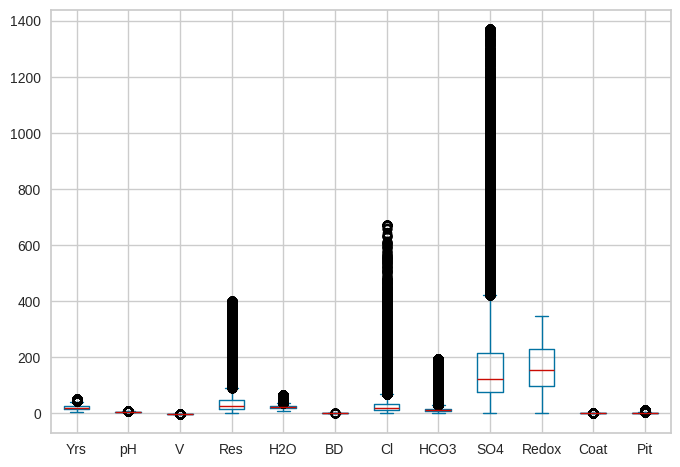

In [4]:
dfs['CTGAN'].plot.box()
plt.show()

0.15  is Minimum deviation index: 1 at column CopulaGANSynthesizer

Data from dfs['CopulaGANSynthesizer'] at index 1:
Yrs       25.00
pH         6.01
V         -0.83
Res       18.50
H2O       27.80
BD         1.35
Cl        28.82
HCO3      17.42
SO4      198.43
Redox    189.40
Coat       0.70
Pit        1.35
Name: 1, dtype: float64

Minimum deviation value at deviation_results[1]['CopulaGANSynthesizer']:
0.15

Matched index from matched_indices[1]['CopulaGANSynthesizer']:
53.0

Original data from orig_data at matched index:
Yrs       20.00
pH         5.70
V         -1.10
Res      151.00
H2O       13.70
BD         1.28
Cl         9.27
HCO3       5.55
SO4      185.10
Redox    259.00
Coat       0.70
Pit        0.91
Name: _53, dtype: float64


deviation_results:
               CTGAN  CopulaGANSynthesizer  GaussianCopula  TVAESynthesizer
count  12243.000000          12243.000000    12243.000000     12243.000000
mean       0.640626              0.641733        0.642472         0.639338
std  

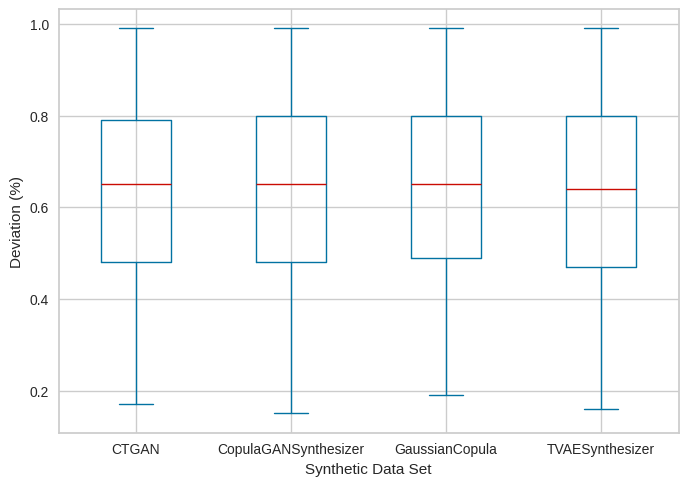

In [5]:
orig_abs = np.abs(orig_data.to_numpy())
orig_np = orig_data.to_numpy()
orig_index = orig_data.index.to_numpy()


@njit
def find_match_indices(df_np, orig_np, orig_abs, pcts, eps):
    n_rows, n_cols = df_np.shape
    n_orig = orig_np.shape[0]
    matches = np.full(n_rows, -1.0)
    devs = np.full(n_rows, np.nan)

    for i in range(n_rows):
        row = df_np[i]
        for p in range(len(pcts)):
            pct = pcts[p]
            for j in range(n_orig):
                valid = True
                for k in range(n_cols):
                    num = abs(orig_np[j, k] - row[k])
                    denom = orig_abs[j, k] + eps
                    if num / denom > pct:
                        valid = False
                        break
                if valid:
                    matches[i] = j
                    devs[i] = pct
                    break
            if devs[i] == devs[i]:  # found a match
                break

    return devs, matches


def find_nearest_match(dfs_, max_samples, min_dev, max_dev, max_pct=1.0, step=0.01, bins=10):
    eps, pcts = 1e-8, np.arange(0, max_pct + step, step)
    bin_edges = np.linspace(min_dev, max_dev, bins + 1)
    max_per_bin = max_samples // bins

    all_bin_counts = {name: [] for name in dfs_}
    devs_matches = {}

    # First pass: collect bin counts for all dfs
    for name, df in dfs_.items():
        df['pit_bin'] = df['Pit'].astype(int)
        counts = df['pit_bin'].value_counts()
        mean_count = int(counts.mean())
        df = df.groupby('pit_bin', group_keys=False).apply(
            lambda x: x.sample(min(mean_count, len(x)))
        ).drop(columns='pit_bin').reset_index(drop=True)
        dfs_[name] = df
        df_np = df.to_numpy()
        devs, matches = find_match_indices(df_np, orig_np, orig_abs, pcts, eps)

        devs_arr = np.array(devs)
        matches_arr = np.array(matches)
        valid_mask = (devs_arr >= min_dev) & (devs_arr <= max_dev)
        devs_arr = devs_arr[valid_mask]
        matches_arr = matches_arr[valid_mask]

        bin_counts = []
        for i in range(bins):
            bin_mask = (devs_arr >= bin_edges[i]) & (devs_arr < bin_edges[i + 1])
            bin_counts.append(np.sum(bin_mask))

        all_bin_counts[name] = bin_counts
        devs_matches[name] = (df, devs_arr, matches_arr, valid_mask)

    # Find the minimum available samples per bin across all dataframes
    min_per_bin = [min([all_bin_counts[name][i] for name in dfs_]) for i in range(bins)]
    min_per_bin = [min(c, max_per_bin) for c in min_per_bin]  # Enforce max per bin

    # Second pass: sample accordingly
    res_dev, res_match, res_sampled_df = {}, {}, {}

    for name, (df, devs_arr, matches_arr, valid_mask) in devs_matches.items():
        df_valid = df.loc[np.where(valid_mask)[0]]
        sampled_indices = []

        for i in range(bins):
            bin_mask = (devs_arr >= bin_edges[i]) & (devs_arr < bin_edges[i + 1])
            bin_indices = np.where(bin_mask)[0]
            if len(bin_indices) > 0 and min_per_bin[i] > 0:
                chosen = np.random.choice(bin_indices, min_per_bin[i], replace=False)
                sampled_indices.extend(chosen)

        devs_sampled = [devs_arr[i] for i in sampled_indices]
        matches_sampled = [matches_arr[i] for i in sampled_indices]
        df_sampled = df_valid.iloc[sampled_indices].reset_index(drop=True)

        res_dev[name] = pd.Series(devs_sampled)
        res_match[name] = pd.Series(matches_sampled)
        res_sampled_df[name] = df_sampled

    return pd.DataFrame(res_dev), pd.DataFrame(res_match), res_sampled_df

###### tune this IMPORTANT
dfsx= copy.deepcopy(dfs)
deviation_results, matched_indices, resampled_dfs = find_nearest_match(dfsx, max_samples=18000, min_dev=0.05, max_dev=1.0)

in_idx, colx = deviation_results.stack().idxmin() #lowest
# in_idx=9; colx='TVAESynthesizer' ##test data
print(deviation_results[colx].iloc[in_idx], f" is Minimum deviation index: {in_idx} at column {colx}")
print(f"\nData from dfs['{colx}'] at index {in_idx}:")
print(dfs[colx].iloc[in_idx])
print(f"\nMinimum deviation value at deviation_results[{in_idx}]['{colx}']:")
print(deviation_results.iloc[in_idx][colx])
print(f"\nMatched index from matched_indices[{in_idx}]['{colx}']:")
print(matched_indices.iloc[in_idx][colx])
print(f"\nOriginal data from orig_data at matched index:")
print(orig_data.iloc[int(matched_indices.iloc[int(in_idx)][colx])])
print("\n\ndeviation_results:\n", deviation_results.describe())
[print(resampled_df,"\n", resampled_dfs[resampled_df].describe()) for resampled_df in resampled_dfs]
deviation_results.plot(kind='box', ylabel='Deviation (%)', xlabel='Synthetic Data Set')
plt.show()

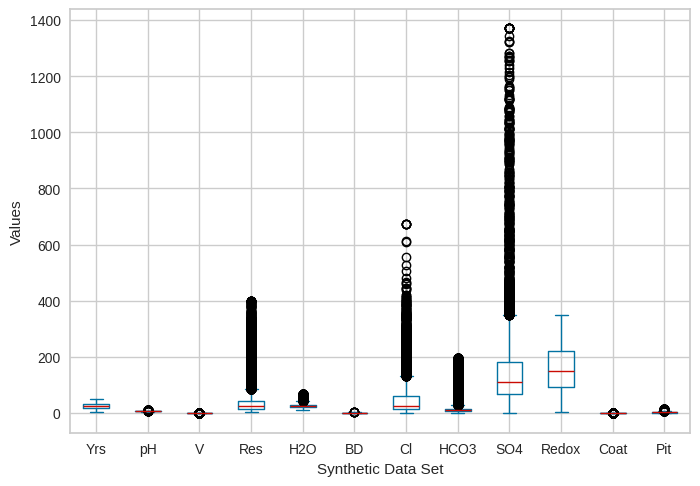

In [6]:
resampled_dfs['CTGAN'].plot(kind='box', ylabel='Values', xlabel='Synthetic Data Set')
plt.show()

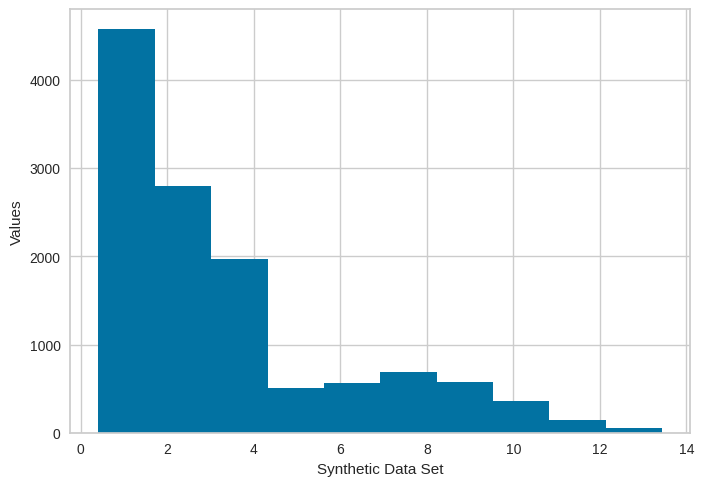

In [7]:
resampled_dfs['CTGAN'].Pit.plot(kind='hist', ylabel='Values', xlabel='Synthetic Data Set')
plt.show()

Lets find the the closest matching rows from a set of dataframes to a reference array (orig_np) based on relative deviation thresholds, and returns the minimum deviation and corresponding match indices for each row.

In [8]:
def train_and_evaluate(variable):
    print("Evaluating generations from ", variable, "...")
    clf1 = setup(data=resampled_dfs[variable], test_data=orig_data, target='Pit', normalize=True, transformation=True, transform_target=False, fold=5, verbose=True)
    best_5 = compare_models(include=['lightgbm', 'gbr', 'rf', 'et', 'xgboost'], n_select=5)
    print("best model is", best_5[0])
    tuned = tune_model(best_5[0], choose_better = True, fold=3)
    best = finalize_model(tuned)
    # best = tune_model(best_5[0], choose_better = True, fold = 2)
    # best = finalize_model(best)
    # print("\n✅ Top 5 models selected:", best, "\n ➡️ Blending the top 5 models...")
    # blended = blend_models(estimator_list=best_5)
    # print("✅ Blending complete. ➡️ Stacking the top 5 models...")
    # stacked = stack_models(estimator_list=best_5)
    # print("✅ Stacking complete.")
    new_data = orig_data.copy()
    y = new_data.pop('Pit')
    pred= predict_model(best, data=new_data)['prediction_label']
    pred.to_csv(variable+'_best.predictions.csv')
    plt.scatter(y, pred)
    plt.xlabel('Original'); plt.ylabel('Predicted'); plt.title('Original vs. Predicted'); plt.grid(True);
    plt.savefig(variable+'.png')
    plt.show()
    # save_model(stacked, variable+'_stacked')
    # save_model(blended, variable+'_blended')
    save_model(best, variable+'_best')
    y_metrics = [explained_variance_score, mean_absolute_error, mean_squared_error,
                lambda y, p: mean_squared_error(y, p, squared=False), median_absolute_error, r2_score]
    names = ["Explained Var", "MAE", "MSE", "RMSE", "Median AE", "R²"]
    loss_dict = {}
    for n, f in zip(names, y_metrics):
        loss= f(y, pred)
        loss_dict[n] = loss
        print(f"{n:>12}: {loss:.4f}")
    return loss_dict

Evaluating generations from  CTGAN ...


,Description,Value
0,Session id,1974
1,Target,Pit
2,Target type,Regression
3,Original data shape,"(12502, 12)"
4,Transformed data shape,"(12502, 12)"
5,Transformed train set shape,"(12243, 12)"
6,Transformed test set shape,"(259, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.2683,3.2169,1.7116,0.4588,0.3564,0.5241,1.4340
lightgbm,Light Gradient Boosting Machine,1.2576,3.2572,1.7214,0.4528,0.3543,0.5114,307.8200
et,Extra Trees Regressor,1.2874,3.2401,1.7195,0.4524,0.3596,0.5543,0.6280
rf,Random Forest Regressor,1.2890,3.3084,1.7384,0.4412,0.3620,0.5480,0.7500
xgboost,Extreme Gradient Boosting,1.3333,3.6230,1.8240,0.3771,0.3789,0.5488,0.6240


best model is GradientBoostingRegressor(random_state=1974)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0333,1.8142,1.3469,0.1520,0.3847,0.7161
1,1.3105,2.9120,1.7065,0.5313,0.3925,0.6893
2,1.8839,6.1124,2.4723,0.4319,0.4144,0.5131
Mean,1.4092,3.6129,1.8419,0.3717,0.3972,0.6395
Std,0.3542,1.8234,0.4693,0.1606,0.0126,0.0900


Fitting 3 folds for each of 10 candidates, totalling 30 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


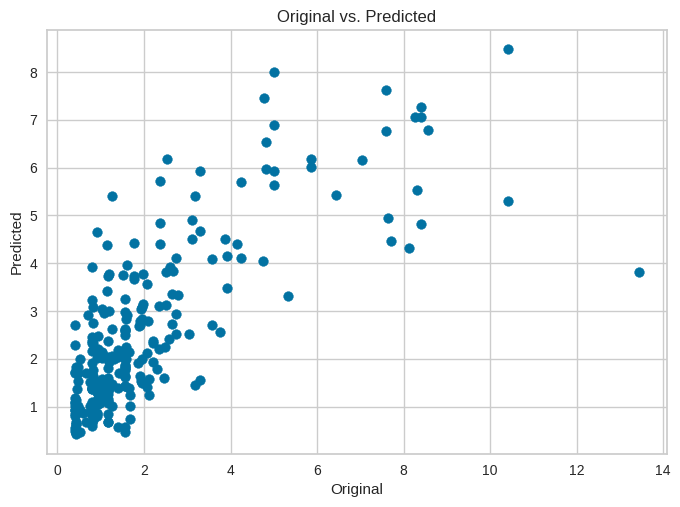

Transformation Pipeline and Model Successfully Saved


Explained Var: 0.5731
         MAE: 0.9631
         MSE: 2.0021
        RMSE: 1.4149
   Median AE: 0.6675
          R²: 0.5202


{'Explained Var': 0.5731186926469135,
 'MAE': 0.9630938234765816,
 'MSE': 2.002062327995627,
 'RMSE': 1.4149425175587973,
 'Median AE': 0.6675229167999013,
 'R²': 0.5201897893112635}

In [9]:
train_and_evaluate("CTGAN")

Evaluating generations from  CopulaGANSynthesizer ...


,Description,Value
0,Session id,559
1,Target,Pit
2,Target type,Regression
3,Original data shape,"(12502, 12)"
4,Transformed data shape,"(12502, 12)"
5,Transformed train set shape,"(12243, 12)"
6,Transformed test set shape,"(259, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.7725,5.2131,2.2076,-0.0159,0.4994,0.9009,1.1140
lightgbm,Light Gradient Boosting Machine,1.7790,5.3608,2.2425,-0.0545,0.5019,0.8834,311.2680
et,Extra Trees Regressor,1.8106,5.3542,2.2500,-0.0710,0.5101,0.9510,0.6380
rf,Random Forest Regressor,1.8188,5.4794,2.2748,-0.0900,0.5129,0.9453,0.8200
xgboost,Extreme Gradient Boosting,1.8772,5.9496,2.3789,-0.2123,0.5330,0.9421,0.6260


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.393913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 9794, number of used features: 11
[LightGBM] [Info] Start training from score 3.740453


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.570683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2021
[LightGBM] [Info] Number of data points in the train set: 9794, number of used features: 11
[LightGBM] [Info] Start training from score 3.404817


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.535135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 9795, number of used features: 11
[LightGBM] [Info] Start training from score 3.184484


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.483347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 9794, number of used features: 11
[LightGBM] [Info] Start training from score 3.590084


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.496120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 9795, number of used features: 11
[LightGBM] [Info] Start training from score 2.957909


best model is GradientBoostingRegressor(random_state=559)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9054,4.5342,2.1294,-1.0269,0.6083,1.5226
1,1.6672,4.1364,2.0338,0.2591,0.5003,1.0632
2,2.5329,10.4430,3.2316,-0.1355,0.5805,0.7622
Mean,2.0351,6.3712,2.4649,-0.3011,0.5631,1.1160
Std,0.3652,2.8838,0.5435,0.5379,0.0458,0.3127


Fitting 3 folds for each of 10 candidates, totalling 30 fits


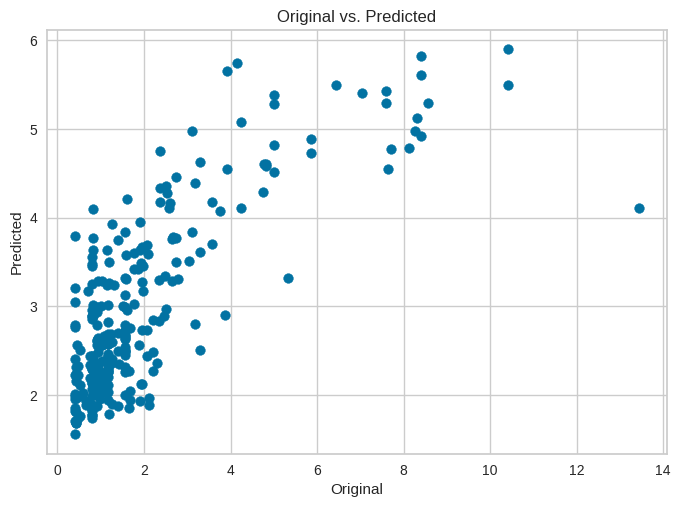

Transformation Pipeline and Model Successfully Saved


Explained Var: 0.5194
         MAE: 1.4567
         MSE: 2.9567
        RMSE: 1.7195
   Median AE: 1.3415
          R²: 0.2914


{'Explained Var': 0.519414958348059,
 'MAE': 1.4566823609584758,
 'MSE': 2.9566636213195534,
 'RMSE': 1.7194951646688494,
 'Median AE': 1.341489845761723,
 'R²': 0.2914119729222756}

In [10]:
train_and_evaluate("CopulaGANSynthesizer")

Evaluating generations from  GaussianCopula ...


,Description,Value
0,Session id,4656
1,Target,Pit
2,Target type,Regression
3,Original data shape,"(12502, 12)"
4,Transformed data shape,"(12502, 12)"
5,Transformed train set shape,"(12243, 12)"
6,Transformed test set shape,"(259, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.1009,1.9269,1.3737,0.3590,0.3712,0.6146,1.2020
lightgbm,Light Gradient Boosting Machine,1.1007,1.9488,1.3822,0.3511,0.3708,0.6009,304.8920
et,Extra Trees Regressor,1.1240,1.9904,1.3978,0.3365,0.3783,0.6404,0.6260
rf,Random Forest Regressor,1.1246,1.9982,1.4005,0.3350,0.3784,0.6376,0.8040
xgboost,Extreme Gradient Boosting,1.1635,2.1808,1.4627,0.2735,0.3933,0.6295,0.6200


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.448855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2019
[LightGBM] [Info] Number of data points in the train set: 9794, number of used features: 11
[LightGBM] [Info] Start training from score 2.900319


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.595384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 9794, number of used features: 11
[LightGBM] [Info] Start training from score 3.100759


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.447458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2021
[LightGBM] [Info] Number of data points in the train set: 9794, number of used features: 11
[LightGBM] [Info] Start training from score 3.004235


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.367312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2017
[LightGBM] [Info] Number of data points in the train set: 9795, number of used features: 11
[LightGBM] [Info] Start training from score 2.694845


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.356583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2018
[LightGBM] [Info] Number of data points in the train set: 9795, number of used features: 11
[LightGBM] [Info] Start training from score 2.845456


best model is GradientBoostingRegressor(random_state=4656)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1892,2.0265,1.4235,0.0904,0.4439,0.9459
1,1.0703,1.8122,1.3462,0.3877,0.3662,0.5956
2,1.3441,2.9408,1.7149,0.2445,0.4044,0.4968
Mean,1.2012,2.2598,1.4949,0.2409,0.4048,0.6794
Std,0.1121,0.4894,0.1587,0.1214,0.0317,0.1927


Fitting 3 folds for each of 10 candidates, totalling 30 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


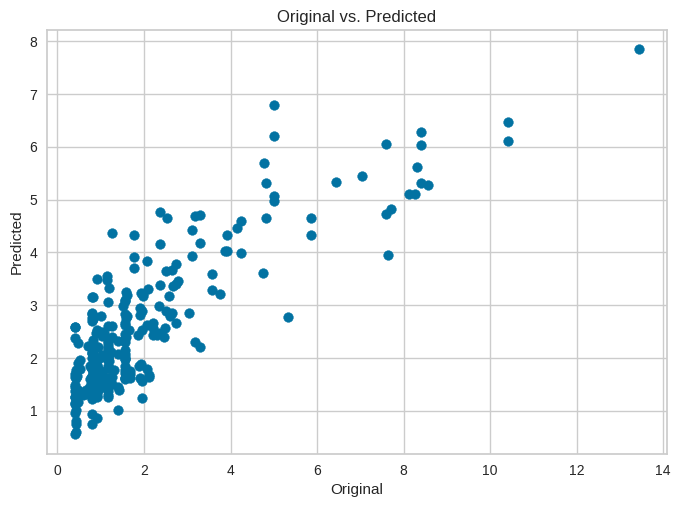

Transformation Pipeline and Model Successfully Saved
Explained Var: 0.6603
         MAE: 1.0263
         MSE: 1.7297
        RMSE: 1.3152


   Median AE: 0.8698
          R²: 0.5855


{'Explained Var': 0.6602523624833623,
 'MAE': 1.0263130307794581,
 'MSE': 1.7297290927975475,
 'RMSE': 1.3151916562986352,
 'Median AE': 0.8698115595622802,
 'R²': 0.58545662198213}

In [11]:
train_and_evaluate("GaussianCopula")

Evaluating generations from  TVAESynthesizer ...


,Description,Value
0,Session id,4162
1,Target,Pit
2,Target type,Regression
3,Original data shape,"(12502, 12)"
4,Transformed data shape,"(12502, 12)"
5,Transformed train set shape,"(12243, 12)"
6,Transformed test set shape,"(259, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.3557,3.5750,1.8168,0.4321,0.3839,0.5660,304.9720
et,Extra Trees Regressor,1.3652,3.5697,1.8187,0.4285,0.3878,0.6034,0.6220
rf,Random Forest Regressor,1.3688,3.6397,1.8348,0.4196,0.3906,0.5993,0.7640
gbr,Gradient Boosting Regressor,1.4577,3.8887,1.8937,0.3832,0.4087,0.6396,1.1720
xgboost,Extreme Gradient Boosting,1.4091,3.8392,1.8901,0.3808,0.4051,0.5923,0.6120


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.446405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2028
[LightGBM] [Info] Number of data points in the train set: 9794, number of used features: 11
[LightGBM] [Info] Start training from score 3.589103


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.442928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2028
[LightGBM] [Info] Number of data points in the train set: 9795, number of used features: 11
[LightGBM] [Info] Start training from score 3.371896


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.474115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2022
[LightGBM] [Info] Number of data points in the train set: 9795, number of used features: 11
[LightGBM] [Info] Start training from score 3.067327


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.568531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 9794, number of used features: 11
[LightGBM] [Info] Start training from score 3.766369


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2032
[LightGBM] [Info] Number of data points in the train set: 9794, number of used features: 11
[LightGBM] [Info] Start training from score 3.954205


best model is LGBMRegressor(n_jobs=-1, random_state=4162)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.2044,2.4285,1.5584,0.1613,0.4215,0.8077
1,1.4598,3.5752,1.8908,0.4247,0.4258,0.7345
2,2.1271,7.6712,2.7697,0.2009,0.4732,0.5593
Mean,1.5971,4.5583,2.0730,0.2623,0.4402,0.7005
Std,0.3890,2.2504,0.5110,0.1160,0.0234,0.1042


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.143404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.075218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.215174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.465146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.683298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.227226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.047402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.184551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.886847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.328494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.664678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.611638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.655231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.547212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.076583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.912591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.963292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.665651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.187251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.021779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.358971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.331233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.558982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.216691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.027315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.347241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.315136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2006
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.231331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.315276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2026
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 11
[LightGBM] [In

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


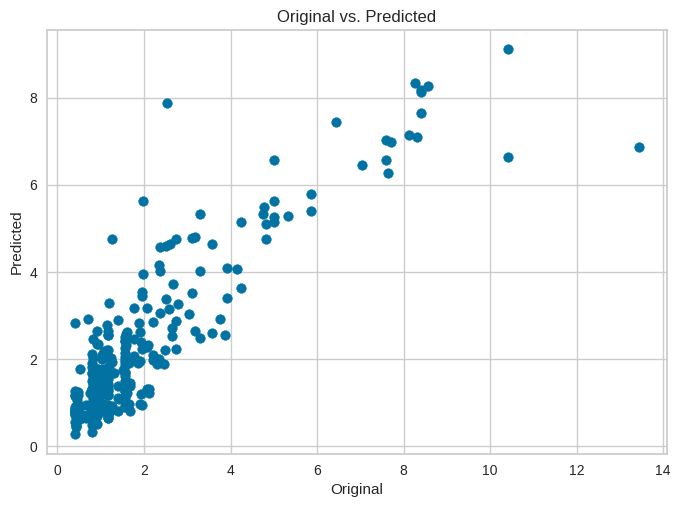

Transformation Pipeline and Model Successfully Saved


Explained Var: 0.7746
         MAE: 0.6884
         MSE: 1.0453
        RMSE: 1.0224
   Median AE: 0.4699
          R²: 0.7495


{'Explained Var': 0.7745570227201604,
 'MAE': 0.6884213010989569,
 'MSE': 1.0453463178993911,
 'RMSE': 1.0224217906027782,
 'Median AE': 0.4699218862951522,
 'R²': 0.7494744144473522}

In [12]:
train_and_evaluate("TVAESynthesizer")

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [13]:
from pycaret.regression import create_app,load_model, predict_model
import gradio as gr
model = load_model("TVAESynthesizer_best")
clf1 = setup(data=resampled_dfs['TVAESynthesizer'], target='Mu (kN⋅m)', normalize=True, transformation=True, transform_target=False, verbose=False)
dfx = pd.DataFrame([[ 0.76, 0.89, 0.4, 0.943]], columns=['t (mm)', 'd (mm)', 'fy (MPa)', 'E (MPa)'])
predict_model(model, data=dfx, round=4)

Transformation Pipeline and Model Successfully Loaded


ValueError: Invalid value for the target parameter. Column Mu (kN⋅m) not found in the data.